In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from numpy.fft import fft, fftfreq
from scipy import stats
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from dtaidistance import dtw
sns.set()

In [2]:
# Load the dataset
file_path = "acquisitions/synthetic_test/processed/processed_all_actions.csv"

# Import the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
data.head()

_time  series_id  measurement_id      action  \
0  2023-12-29 16:50:56.247487          0               0  floating_x   
1  2023-12-29 16:50:56.262481          0               1  floating_x   
2  2023-12-29 16:50:56.276026          0               2  floating_x   
3  2023-12-29 16:50:56.291837          0               3  floating_x   
4  2023-12-29 16:50:56.306791          0               4  floating_x   

     gyro_x    gyro_y    gyro_z   accel_x   accel_y   accel_z  quat_x  quat_y  \
0  1.865854  0.323171  0.243902  0.004321 -0.004956  0.010840    -0.7    0.68   
1  1.865854  0.323171  0.243902  0.004321 -0.004956  0.010840    -0.7    0.68   
2  1.743902 -0.164634  0.182927  0.004077  0.000659  0.006201    -0.7    0.68   
3  0.280488 -1.506098  0.243902  0.003345 -0.003735 -0.007471    -0.7    0.68   
4 -0.878049 -1.567073 -0.060976  0.004565 -0.008130 -0.011377    -0.7    0.68   

   quat_z  quat_w  
0    0.21     0.1  
1    0.21     0.1  
2    0.21     0.1  
3    0.21     0.1  
4    0.21     0.1

In [4]:
data.describe()

series_id  measurement_id       gyro_x       gyro_y       gyro_z  \
count  3457.000000     3457.000000  3457.000000  3457.000000  3457.000000   
mean      5.216951      170.265259    -4.114510     0.755942    -0.869745   
std       3.722790      121.300390    71.090067    74.537029    65.122563   
min       0.000000        0.000000  -777.884146  -337.158537  -232.682927   
25%       2.000000       72.000000    -8.073171    -9.926829   -15.280488   
50%       5.000000      149.000000     0.146341     0.030488    -0.146341   
75%       9.000000      248.000000    15.128049    10.182927     6.024390   
max      11.000000      500.000000   203.975610   576.463415   715.134146   

           accel_x      accel_y      accel_z       quat_x       quat_y  \
count  3457.000000  3457.000000  3457.000000  3457.000000  3457.000000   
mean     -0.106049    -0.097238     0.046940     0.051449     0.272953   
std       0.437289     0.338756     0.441120     0.630403     0.530645   
min      -1.948242    -2.094897    -0.991528    -0.980000    -0.980000   
25%      -0.266504    -0.099365    -0.023169    -0.610000    -0.210000   
50%      -0.001611    -0.008472     0.007153     0.210000     0.530000   
75%       0.033301     0.009595     0.091650     0.640000     0.690000   
max       1.710742     0.819019     2.023047     0.990000     0.990000   

            quat_z       quat_w  
count  3457.000000  3457.000000  
mean      0.070223     0.254709  
std       0.357432     0.216536  
min      -0.990000     0.000000  
25%      -0.170000     0.070000  
50%       0.100000     0.180000  
75%       0.320000     0.430000  
max       1.000000     0.970000

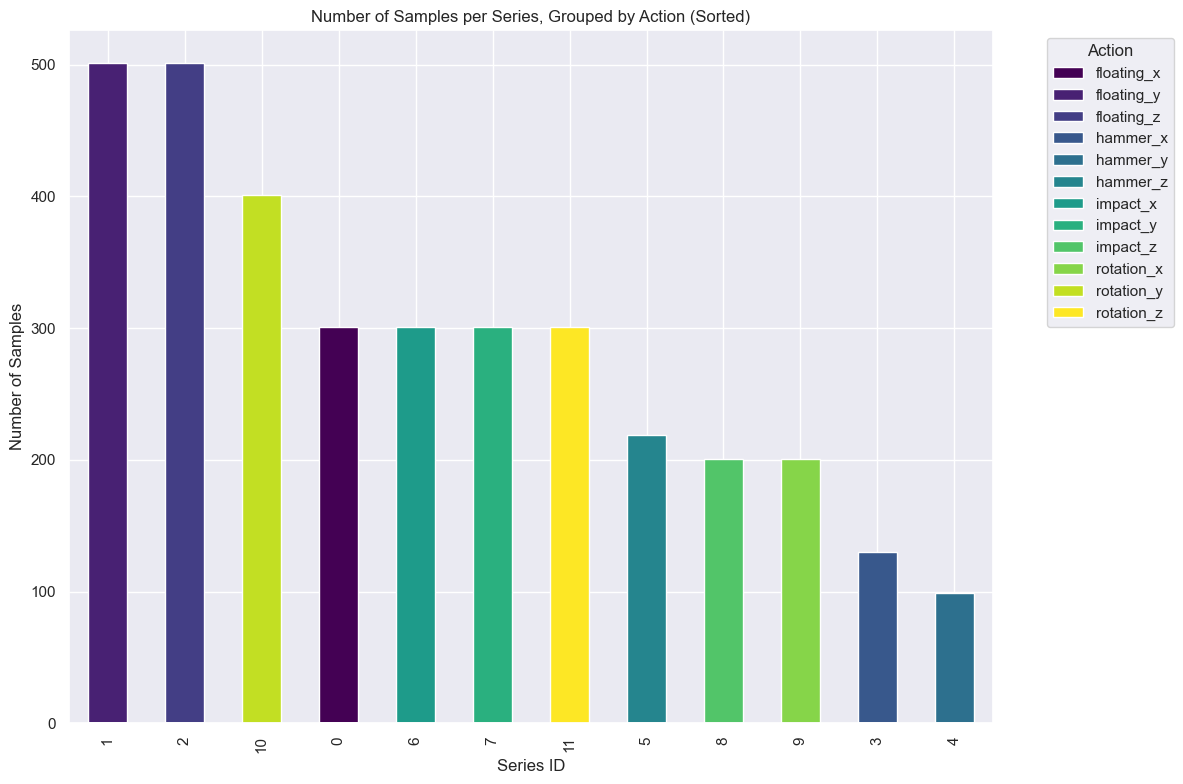

In [5]:
# Grouping data by series_id and action
grouped_data = data.groupby(['series_id', 'action']).size().unstack(fill_value=0)

# Sorting the grouped data by the total number of samples in each series, from highest to lowest
sorted_grouped_data = grouped_data.sum(axis=1).sort_values(ascending=False)
sorted_grouped_data = grouped_data.loc[sorted_grouped_data.index]

# Plotting the sorted histogram
ax = sorted_grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Number of Samples per Series, Grouped by Action (Sorted)')
plt.xlabel('Series ID')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _time           3457 non-null   object 
 1   series_id       3457 non-null   int64  
 2   measurement_id  3457 non-null   int64  
 3   action          3457 non-null   object 
 4   gyro_x          3457 non-null   float64
 5   gyro_y          3457 non-null   float64
 6   gyro_z          3457 non-null   float64
 7   accel_x         3457 non-null   float64
 8   accel_y         3457 non-null   float64
 9   accel_z         3457 non-null   float64
 10  quat_x          3457 non-null   float64
 11  quat_y          3457 non-null   float64
 12  quat_z          3457 non-null   float64
 13  quat_w          3457 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 378.2+ KB


In [7]:
# function to calculate correlation matrix of one series
def plot_correlation_matrix(data, action):

    # Getting the series ID for the action
    series_id = data[data['action'] == action]['series_id'].iloc[0]
    # Filter data for the specific series_id and action
    filtered_data = data[(data['series_id'] == series_id) & (data['action'] == action)]
    # Select only float columns
    numeric_data = filtered_data.select_dtypes(include=[np.float64])

    # Calculate the correlation matrix
    corr_matrix = numeric_data.corr()

    # Plotting the heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Correlation Matrix for Series ID {series_id} and Action {action}')
    plt.show()

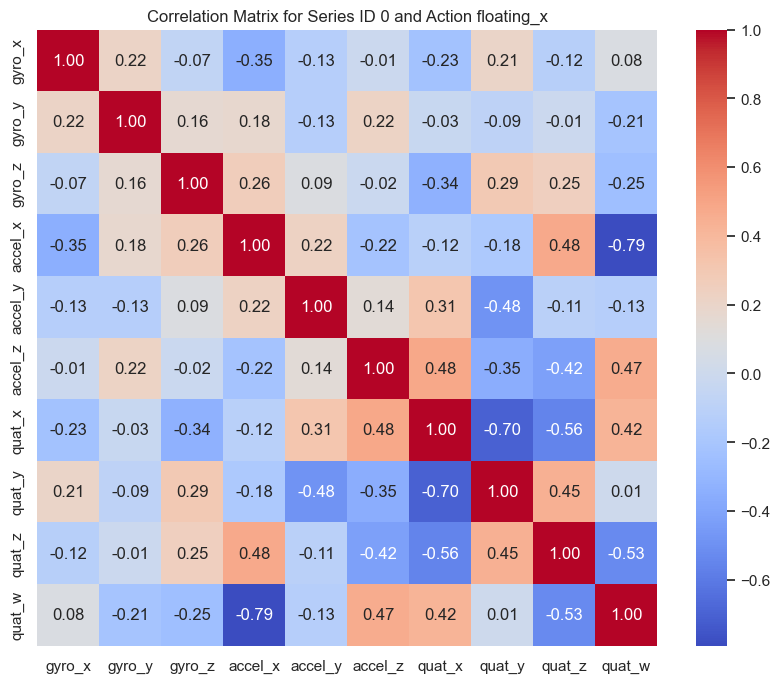

In [8]:
plot_correlation_matrix(data,'floating_x')

In [9]:
# Convert '_time' to datetime and calculate time differences
data['_time'] = pd.to_datetime(data['_time'])
data['time_diff'] = data.groupby('series_id')['_time'].diff()

# Dropping NaN values
data_cleaned = data.dropna()

# Converting the time differences from timedelta to float (in seconds) for easier plotting
data_cleaned['time_diff_seconds'] = data_cleaned['time_diff'].dt.total_seconds()

C:\Users\MegaN\AppData\Local\Temp\ipykernel_17008\3005622164.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['time_diff_seconds'] = data_cleaned['time_diff'].dt.total_seconds()


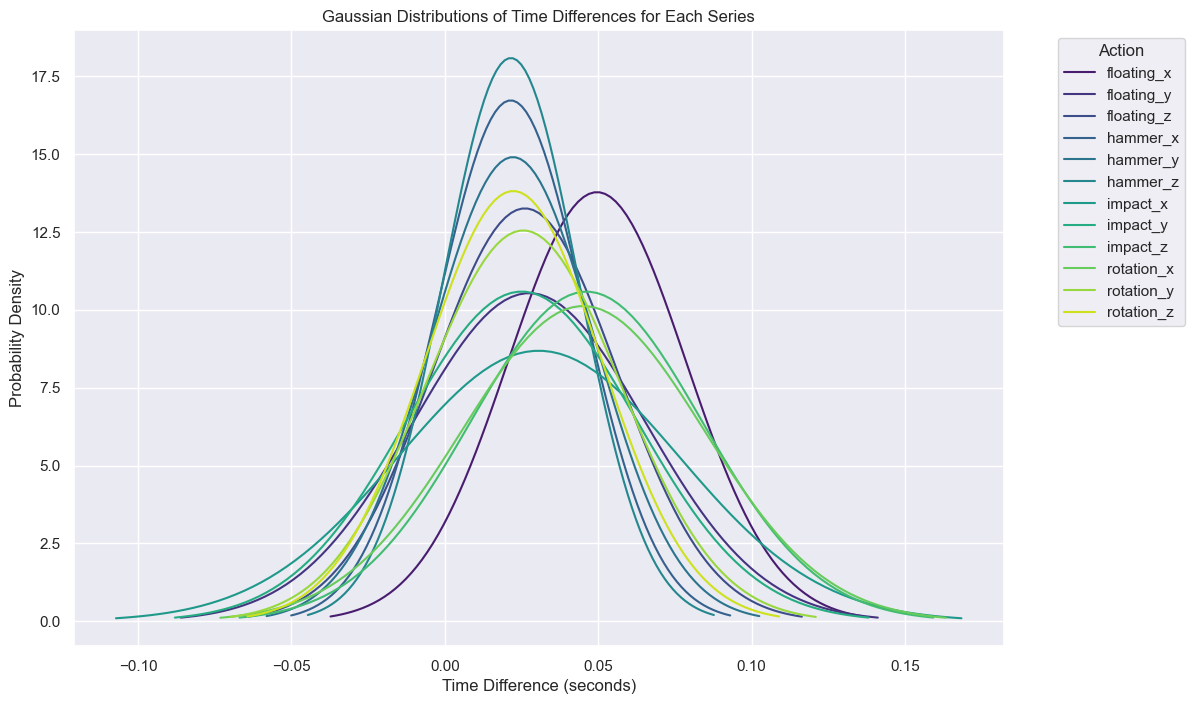

In [10]:
# Create a mapping of series_id to action
action_mapping = data_cleaned.dropna().groupby('series_id')['action'].first().to_dict()

# Setting up the color palette to match the histogram colors
palette = sns.color_palette('viridis', n_colors=len(data_cleaned['series_id'].unique()))

# Plotting Gaussian distributions with the same colors as the histogram
plt.figure(figsize=(12, 8))

# Generating Gaussian plots for each series
for idx, series_id in enumerate(sorted(data_cleaned['series_id'].unique())):
    # Selecting the series
    series_data = data_cleaned[data_cleaned['series_id'] == series_id]['time_diff_seconds']
    
    # Calculating mean and standard deviation
    mean = series_data.mean()
    std = series_data.std()
    
    # Generating points for the Gaussian curve
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    # Plotting with action name in the label
    action_name = action_mapping.get(series_id, 'Unknown')
    plt.plot(x, y, label=f'{action_name}', color=palette[idx])

# Adding title, labels, and legend
plt.title('Gaussian Distributions of Time Differences for Each Series')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Probability Density')
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
# show bar on top of grid
plt.gca().set_axisbelow(True)
# Show plot
plt.show()


In [11]:
def oversample_dataset(data, sample_time):
    # Empty DataFrame to store the oversampled data
    oversampled_data = pd.DataFrame()

    # Remove time_diff column
    data = data.drop(columns=['time_diff'], errors='ignore')

    # Get the length of each series after resampling
    series_length = []

    # Iterate over each series to calculate its length after resampling
    for series_id in data['series_id'].unique():
        # Filter and resample the data for the current series
        series_data = data[data['series_id'] == series_id]
        numeric_data = series_data.select_dtypes(include=[np.number, 'datetime64[ns]'])
        resampled_data = numeric_data.resample(f'{sample_time}S', on='_time').mean()
        series_length.append(len(resampled_data))

    # Calculate the length of the longest series
    max_length = max(series_length)

    # Iterate over each series again to pad them
    for series_id, length in zip(data['series_id'].unique(), series_length):
        # Filter and resample the data for the current series
        series_data = data[data['series_id'] == series_id]
        numeric_data = series_data.select_dtypes(include=[np.number, 'datetime64[ns]'])
        resampled_data = numeric_data.resample(f'{sample_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')

        # Pad the series if it is shorter than the longest series
        if length < max_length:
            padding_length = max_length - length
            padding_df = pd.DataFrame(0.0, index=np.arange(padding_length), columns=resampled_data.columns)
            padding_df['series_id'] = series_id  # Set series_id for the padding
            resampled_data = pd.concat([resampled_data, padding_df], ignore_index=True)

        # Refactor measurement_id to be sequential for each series_id
        resampled_data['measurement_id'] = np.arange(len(resampled_data))

        # Append the processed series data to the oversampled_data DataFrame
        oversampled_data = pd.concat([oversampled_data, resampled_data], ignore_index=True)

        # convert series_id to int
        oversampled_data['series_id'] = oversampled_data['series_id'].astype(int)
        
        # add action column based on the action mapping
        oversampled_data['action'] = oversampled_data['series_id'].map(action_mapping)

    # Return the oversampled dataset
    return oversampled_data

In [12]:
# print the mean and standard deviation of the time differences for each series
series_mean = []
series_std = []

for series_id in data_cleaned['series_id'].unique():
    series_data = data_cleaned[data_cleaned['series_id'] == series_id]['time_diff_seconds']
    series_mean.append(series_data.mean())
    series_std.append(series_data.std())
    # print(f'Series {series_id}: mean = {series_data.mean()}, std = {series_data.std()}')

print('-------------------')

# print minimum and maximum mean and standard deviation
print(f'Minimum mean: {min(series_mean)}')
print(f'Maximum mean: {max(series_mean)}')
print(f'Minimum std: {min(series_std)}')
print(f'Maximum std: {max(series_std)}')

print('-------------------')

sampling_time = round(max(series_mean), 2)
print(f'Sampling time: {sampling_time} seconds')

-------------------
Minimum mean: 0.021462023255813957
Maximum mean: 0.04959692666666667
Minimum std: 0.022060028831696925
Maximum std: 0.045933133781250725
-------------------
Sampling time: 0.05 seconds


In [13]:
oversample_data = oversample_dataset(data, sampling_time)

In [14]:
oversample_data

series_id  measurement_id    gyro_x    gyro_y    gyro_z   accel_x  \
0             0               0  1.865854  0.323171  0.243902  0.004321   
1             0               1  1.296748 -0.449187  0.223577  0.003914   
2             0               2 -1.335366 -1.048780 -0.365854  0.004321   
3             0               3 -0.658537  0.701220  0.195122 -0.004956   
4             0               4 -0.735772 -0.002033  0.650407 -0.001213   
...         ...             ...       ...       ...       ...       ...   
3583         11             294  0.000000  0.000000  0.000000  0.000000   
3584         11             295  0.000000  0.000000  0.000000  0.000000   
3585         11             296  0.000000  0.000000  0.000000  0.000000   
3586         11             297  0.000000  0.000000  0.000000  0.000000   
3587         11             298  0.000000  0.000000  0.000000  0.000000   

       accel_y   accel_z  quat_x  quat_y  quat_z  quat_w      action  
0    -0.004956  0.010840    -0.7    0.68    0.21     0.1  floating_x  
1    -0.002677  0.003190    -0.7    0.68    0.21     0.1  floating_x  
2    -0.006787 -0.010400    -0.7    0.68    0.21     0.1  floating_x  
3     0.005249 -0.000049    -0.7    0.68    0.21     0.1  floating_x  
4     0.003101 -0.002262    -0.7    0.68    0.21     0.1  floating_x  
...        ...       ...     ...     ...     ...     ...         ...  
3583  0.000000  0.000000     0.0    0.00    0.00     0.0  rotation_z  
3584  0.000000  0.000000     0.0    0.00    0.00     0.0  rotation_z  
3585  0.000000  0.000000     0.0    0.00    0.00     0.0  rotation_z  
3586  0.000000  0.000000     0.0    0.00    0.00     0.0  rotation_z  
3587  0.000000  0.000000     0.0    0.00    0.00     0.0  rotation_z  

[3588 rows x 13 columns]

In [15]:
feature_plot = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

# function to plot acceleration data for a given series
def plot_acceleration_data(data, action):
    
    # Getting the series ID for the action
    series_id = data[data['action'] == action]['series_id'].iloc[0]
    # Selecting the series
    series_data = data[data['series_id'] == series_id]
    
    # Plotting the acceleration data in a 2x3 grid
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f'Acceleration Data for Series {series_id} - {action_mapping.get(series_id, "Unknown")}')

    # Plotting each feature
    for idx, feature in enumerate(feature_plot):
        # Calculating the row and column index
        row = idx // 3
        col = idx % 3
        
        color_plot = 'blue'

        if row == 0:
            axs[row, col].set_ylabel('Acceleration (g)')
        else:
            axs[row, col].set_ylabel('Angular Velocity (deg/s)')

        if col == 0:
            # make plot color blue
            color_plot = 'C0'
        elif col == 1:
            # make plot color orange
            color_plot = 'C1'
        else:
            # make plot color green
            color_plot = 'C2'

        # Plotting the feature
        axs[row, col].plot(series_data['measurement_id'], series_data[feature], color=color_plot)
        axs[row, col].set_title(feature)
        axs[row, col].set_xlabel('Measurement ID')
        axs[row, col].grid(True)
        axs[row, col].set_axisbelow(True)      

    # Adjusting the spacing between plots
    fig.tight_layout(pad=3.0)

    # Show plot
    plt.show()

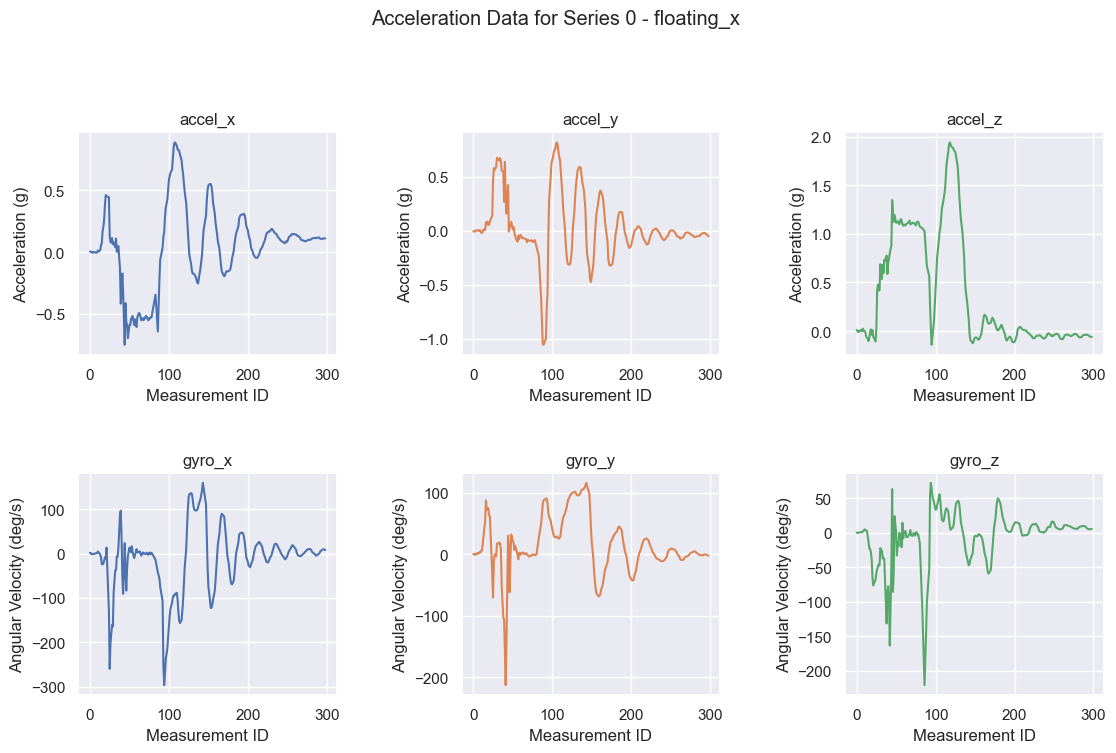

In [16]:
plot_acceleration_data(oversample_data, 'floating_x')
# plot_acceleration_data(oversample_data, 'rotation_y')
# plot_acceleration_data(oversample_data, 'impact_x')
# plot_acceleration_data(oversample_data, 'hammer_x')

In [17]:
# Define the FFT function
def mfft(x, length):
    return [x / math.sqrt(length) for x in np.absolute(np.fft.fft(x))][1:]

# Prepare the data with FFT analysis
def prepare_data(data):
    def extract_series_features(series_data):
        features_fft = {}
        length = len(series_data)
        for feature in ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']:
            # Apply FFT and store the results in a dictionary
            features_fft[f'{feature}_f'] = mfft(series_data[feature].values, length)
        # Add the 'action' column to the features
        features_fft['action'] = series_data['action'].values[0]
        return pd.Series(features_fft)

    # Group the data by 'series_id' and apply the FFT function to each group
    data_grouped = data.groupby('series_id').apply(extract_series_features).reset_index()

    return data_grouped

In [18]:
# function to calculate mean and standard deviation for each feature
def aggf(d, feature):
    va = np.array(d[feature].tolist())
    mean = np.mean(va, axis=0)
    var = np.var(va, axis=0)
    dev = np.sqrt(var)
    return pd.DataFrame({
        'mean': [mean],
        'dev': [dev],
    })

display={
'floating_x':'C0-+',
'floating_y':'C1-+',
'floating_z':'C2-+',
# 'rotation_x':'C3--',
# 'rotation_y':'C4--',
# 'rotation_z':'C5--',
# 'impact_x':'C6-*',
# 'impact_y':'C7-*',
# 'impact_z':'C8-*',
# 'hammer_x':'C9',
# 'hammer_y':'C10',
# 'hammer_z':'C11',
}

In [19]:
# Define the function to plot the FFT of a given action
def plot_fft_single_action(fft_data, action_name):
    # Filtering the dataset for the specified action
    action_data = fft_data[fft_data['action'] == action_name]

    # Initialize the figure
    plt.figure(figsize=(14, 8))

    color = ['C0', 'C1', 'C2', 'C0', 'C1', 'C2']
    # Iterate over the features and create subplots
    for i, feature in enumerate(['accel_x_f', 'accel_y_f', 'accel_z_f', 'gyro_x_f', 'gyro_y_f', 'gyro_z_f']):
        # Calculate mean FFT for the feature
        fft_values = np.array(action_data[feature].values.tolist())
        mean_fft = np.mean(fft_values, axis=0)

        # Plotting
        plt.subplot(2, 3, i + 1)
        plt.plot(mean_fft, label=f"{feature} of {action_name}", color=color[i])
        plt.title(f"{feature} of {action_name}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [20]:
fft_data = prepare_data(oversample_data)

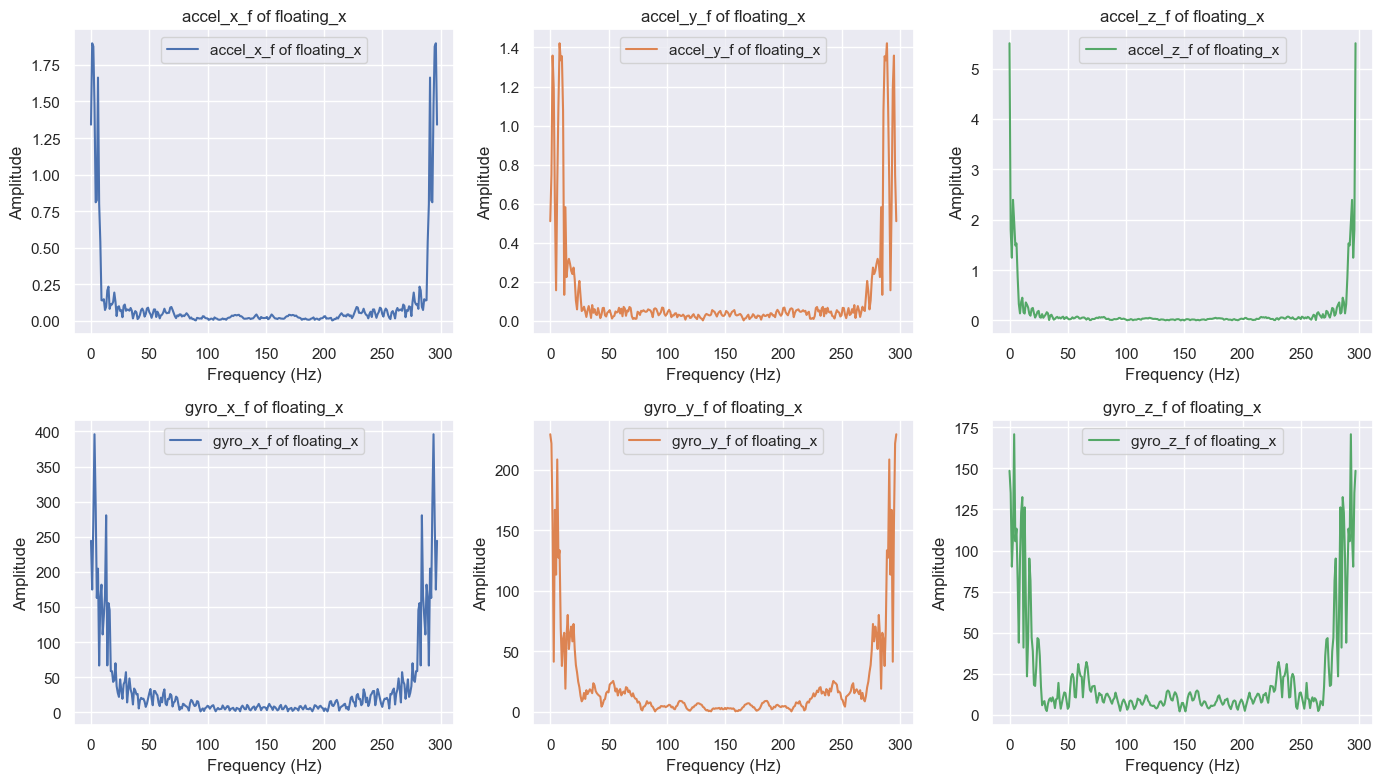

In [21]:
plot_fft_single_action(fft_data, 'floating_x')
# plot_fft_single_action(fft_data, 'rotation_y')
# plot_fft_single_action(fft_data, 'impact_z')
# plot_fft_single_action(fft_data, 'hammer_z')

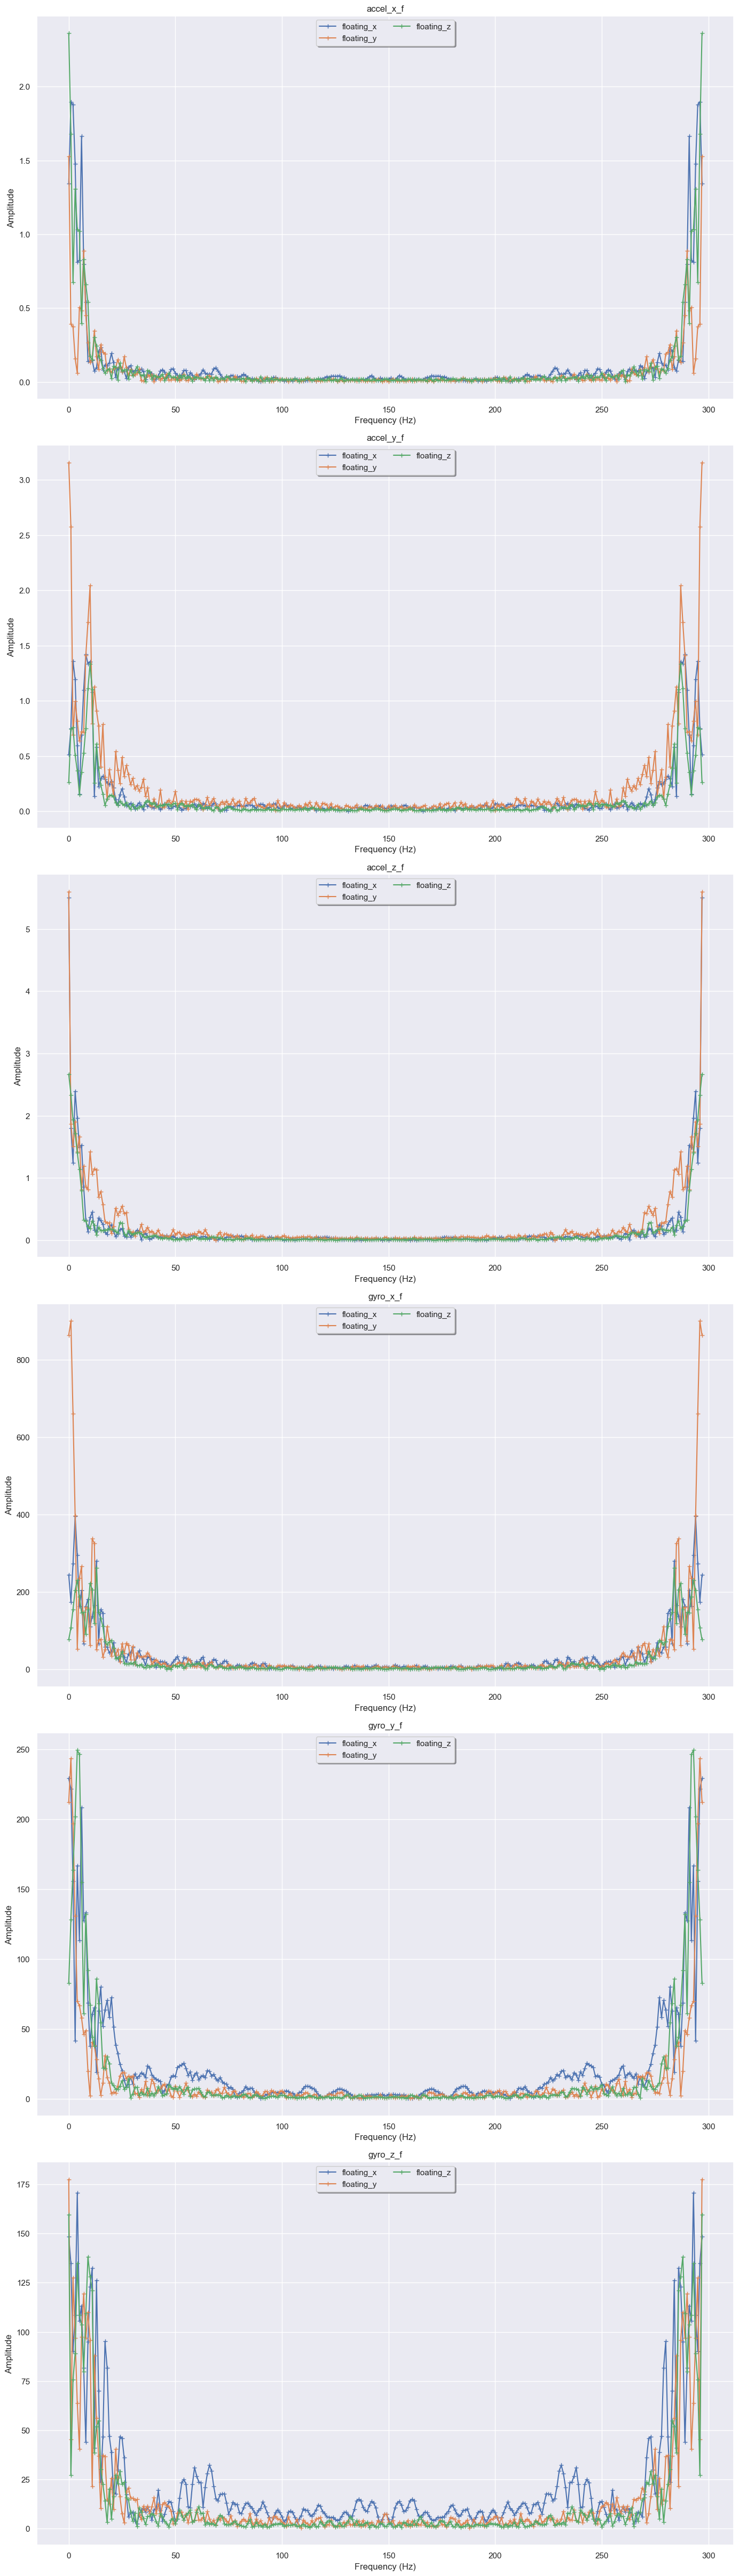

In [22]:
# Now, let's plot the mean FFT amplitude for each feature, grouped by the action type
plt.figure(figsize=(14, 8 * 7))
features = ['accel_x_f', 'accel_y_f', 'accel_z_f', 'gyro_x_f', 'gyro_y_f', 'gyro_z_f']
count = 0

for feature in features:
    # Calculate the mean and standard deviation for each action
    stat = fft_data.groupby('action').apply(aggf, feature)
    stat.index = stat.index.droplevel(-1)
    
    # Ensure there's at least one action type to get the length for plotting
    if not stat.empty:
        b = [*range(len(stat.iloc[0]['mean']))]

        count += 1
        plt.subplot(len(features) + 1, 1, count)
        for action_type in display.keys():
            # Check if the current action type exists in the data
            if action_type in stat.index:
                plt.plot(b, stat.at[action_type, 'mean'], display[action_type], label=action_type)

        plt.legend(loc='best', ncol=2, shadow=True, fancybox=True)
        plt.title(f"{feature}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [23]:
data

_time  series_id  measurement_id      action  \
0    2023-12-29 16:50:56.247487          0               0  floating_x   
1    2023-12-29 16:50:56.262481          0               1  floating_x   
2    2023-12-29 16:50:56.276026          0               2  floating_x   
3    2023-12-29 16:50:56.291837          0               3  floating_x   
4    2023-12-29 16:50:56.306791          0               4  floating_x   
...                         ...        ...             ...         ...   
3452 2023-12-29 16:58:16.012691         11             296  rotation_z   
3453 2023-12-29 16:58:16.184144         11             297  rotation_z   
3454 2023-12-29 16:58:16.191118         11             298  rotation_z   
3455 2023-12-29 16:58:16.196101         11             299  rotation_z   
3456 2023-12-29 16:58:16.305037         11             300  rotation_z   

         gyro_x     gyro_y     gyro_z   accel_x   accel_y   accel_z  quat_x  \
0      1.865854   0.323171   0.243902  0.004321 -0.004956  0.010840   -0.70   
1      1.865854   0.323171   0.243902  0.004321 -0.004956  0.010840   -0.70   
2      1.743902  -0.164634   0.182927  0.004077  0.000659  0.006201   -0.70   
3      0.280488  -1.506098   0.243902  0.003345 -0.003735 -0.007471   -0.70   
4     -0.878049  -1.567073  -0.060976  0.004565 -0.008130 -0.011377   -0.70   
...         ...        ...        ...       ...       ...       ...     ...   
3452   1.079268  54.853659  10.439024  0.135425 -0.475269 -0.611646    0.93   
3453   5.957317  49.792683  10.378049  0.147876 -0.475513 -0.609692    0.93   
3454  23.213415  29.792683  10.378049  0.176685 -0.476489 -0.608472    0.92   
3455  41.079268   2.292683  10.256098  0.208911 -0.498950 -0.618970    0.92   
3456  44.981707  -5.024390  10.012195  0.211353 -0.508228 -0.625562    0.92   

      quat_y  quat_z  quat_w              time_diff  
0       0.68    0.21    0.10                    NaT  
1       0.68    0.21    0.10 0 days 00:00:00.014994  
2       0.68    0.21    0.10 0 days 00:00:00.013545  
3       0.68    0.21    0.10 0 days 00:00:00.015811  
4       0.68    0.21    0.10 0 days 00:00:00.014954  
...      ...     ...     ...                    ...  
3452    0.16    0.24    0.22 0 days 00:00:00.006964  
3453    0.16    0.25    0.22 0 days 00:00:00.171453  
3454    0.18    0.27    0.21 0 days 00:00:00.006974  
3455    0.18    0.28    0.19 0 days 00:00:00.004983  
3456    0.18    0.28    0.19 0 days 00:00:00.108936  

[3457 rows x 15 columns]

In [24]:
def plot_top_fft_peaks(grouped_data, components, max_length, sampling_time):
    fig, axes = plt.subplots(len(grouped_data), 1, figsize=(15, 30))
    fig.tight_layout(pad=5.0)
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i, (action, group) in enumerate(grouped_data):
        padded_group = {comp: np.pad(group[comp].to_numpy(), (0, max_length - len(group[comp])), 'constant') for comp in components}

        for j, comp in enumerate(components):
            fft_values = fft(padded_group[comp])
            fft_freq = np.fft.fftfreq(len(padded_group[comp]), d=sampling_time)

            peaks, _ = find_peaks(np.abs(fft_values)[:len(padded_group[comp])//2])
            top_peaks_indices = np.argsort(np.abs(fft_values[peaks]))[-5:]
            top_freqs = fft_freq[peaks][top_peaks_indices]
            top_amplitudes = np.abs(fft_values[peaks])[top_peaks_indices]

            axes[i].stem(top_freqs, top_amplitudes, linefmt=f'{colors[j]}-', markerfmt=f'{colors[j]}o', basefmt=' ', label=f"{comp} peaks")

        axes[i].set_title(f"Top 5 FFT Peaks for Action: {action}")
        axes[i].set_xlabel("Frequency (Hz)")
        axes[i].set_ylabel("Amplitude")
        axes[i].legend()

    plt.show()


In [25]:
def plot_interpolated_fft(grouped_data, components, max_length, sampling_time):
    fig, axes = plt.subplots(len(grouped_data), 1, figsize=(15, 30))
    fig.tight_layout(pad=5.0)
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i, (action, group) in enumerate(grouped_data):
        padded_group = {comp: np.pad(group[comp].to_numpy(), (0, max_length - len(group[comp])), 'constant') for comp in components}

        for j, comp in enumerate(components):
            fft_values = fft(padded_group[comp])
            fft_freq = np.fft.fftfreq(len(padded_group[comp]), d=sampling_time)

            peaks, _ = find_peaks(np.abs(fft_values)[:len(padded_group[comp])//2])
            top_peaks_indices = np.argsort(np.abs(fft_values[peaks]))[-5:]
            top_freqs = fft_freq[peaks][top_peaks_indices]
            top_amplitudes = np.abs(fft_values[peaks])[top_peaks_indices]

            if len(top_freqs) > 1:
                f_interp = interp1d(top_freqs, top_amplitudes, kind='quadratic', fill_value="extrapolate")
                freqs_new = np.linspace(top_freqs.min(), top_freqs.max(), num=400)
                amps_new = f_interp(freqs_new)
                axes[i].plot(freqs_new, amps_new, label=f"{comp} (interp)", color=colors[j], linewidth=2)

        axes[i].set_title(f"Interpolated FFT Peaks for Action: {action}")
        axes[i].set_xlabel("Frequency (Hz)")
        axes[i].set_ylabel("Amplitude")
        axes[i].legend()

    plt.show()


In [26]:
def plot_fft_peaks_with_interpolation(grouped_data, components, max_length, sampling_time):
    fig, axes = plt.subplots(len(grouped_data), 1, figsize=(15, 45))
    fig.tight_layout(pad=5.0)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    
    for i, (action, group) in enumerate(grouped_data):
        padded_group = {comp: np.pad(group[comp].to_numpy(), (0, max_length - len(group[comp])), 'constant') for comp in components}

        for j, comp in enumerate(components):
            # Perform FFT and find peaks
            fft_values = fft(padded_group[comp])
            fft_freq = np.fft.fftfreq(len(padded_group[comp]), d=sampling_time)
            peaks, _ = find_peaks(np.abs(fft_values)[:len(padded_group[comp])//2])
            top_peaks_indices = np.argsort(np.abs(fft_values[peaks]))[-5:]
            top_freqs = fft_freq[peaks][top_peaks_indices]
            top_amplitudes = np.abs(fft_values[peaks])[top_peaks_indices]

            # Plotting the top peaks with stem
            axes[i].stem(top_freqs, top_amplitudes, linefmt=f'{colors[j]}-', markerfmt=f'{colors[j]}o', basefmt=' ', label=f"{comp} peaks")

            # Interpolation of the top peaks
            if len(top_freqs) > 1:
                f_interp = interp1d(top_freqs, top_amplitudes, kind='quadratic', fill_value="extrapolate")
                freqs_new = np.linspace(top_freqs.min(), top_freqs.max(), num=400)
                amps_new = f_interp(freqs_new)
                # Plotting the interpolated curves
                axes[i].plot(freqs_new, amps_new, label=f"{comp} (interp)", color=colors[j], alpha=0.5, linewidth=3)

        axes[i].set_title(f"FFT Peaks and Interpolation for Action: {action}")
        axes[i].set_xlabel("Frequency (Hz)")
        axes[i].set_ylabel("Amplitude")
        axes[i].legend()

    plt.show()


In [27]:
def interpolate_all_components(group, components, max_length, sampling_time, tolerance=0.05):
    # Dictionary to hold the combined frequencies and amplitudes
    all_freqs = {}
    all_amplitudes = {}

    # Padding and FFT for each component
    padded_group = {comp: np.pad(group[comp].to_numpy(), (0, max_length - len(group[comp])), 'constant') for comp in components}
    for comp in components:
        fft_values = fft(padded_group[comp])
        fft_freq = np.fft.fftfreq(len(padded_group[comp]), d=sampling_time)
        
        # Find peaks for positive frequencies
        peaks, _ = find_peaks(np.abs(fft_values)[:len(padded_group[comp])//2])
        freqs = fft_freq[peaks]
        amplitudes = np.abs(fft_values[peaks])

        # Combine peaks from all components, keeping the highest amplitude for close frequencies
        for f, a in zip(freqs, amplitudes):
            if not any(np.isclose(f, list(all_freqs.keys()), atol=tolerance)):
                all_freqs[f] = a
            else:
                # If the frequency is close to an existing one, keep the highest amplitude
                existing_freq = min(all_freqs.keys(), key=lambda existing_f: abs(existing_f - f))
                if all_freqs[existing_freq] < a:
                    del all_freqs[existing_freq]
                    all_freqs[f] = a

    # Now that we have all frequencies and amplitudes, we can interpolate
    # Sort the frequencies to ensure proper interpolation
    sorted_freqs = np.array(sorted(all_freqs.keys()))
    sorted_amplitudes = np.array([all_freqs[freq] for freq in sorted_freqs])

    # Create the interpolation function if we have enough points
    if len(sorted_freqs) > 1:
        f_interp = interp1d(sorted_freqs, sorted_amplitudes, kind='quadratic', fill_value="extrapolate")
        return f_interp, sorted_freqs, sorted_amplitudes
    else:
        # Not enough points to interpolate, return None
        return None, sorted_freqs, sorted_amplitudes

# Plotting the interpolation for each sequence
def plot_single_interpolated_function(grouped_data, components, max_length, sampling_time, tolerance=0.1):
    # Create subplots for each action
    fig, axes = plt.subplots(len(grouped_data), 1, figsize=(14, 7 * len(grouped_data)))
    
    for ax, (action, group) in zip(axes, grouped_data):
        f_interp, sorted_freqs, sorted_amplitudes = interpolate_all_components(group, components, max_length, sampling_time, tolerance)
        
        if f_interp is not None:
            # Generate new interpolated data
            freqs_new = np.linspace(sorted_freqs.min(), sorted_freqs.max(), num=400)
            amps_new = f_interp(freqs_new)
            # Plotting the interpolated curve in the corresponding subplot
            ax.plot(freqs_new, amps_new, label=f"{action} (interp)")
        
        # Plotting the original peaks in the corresponding subplot
        ax.scatter(sorted_freqs, sorted_amplitudes, label=f"{action} (peaks)", zorder=5)

        ax.set_title(f'Interpolated FFT for {action}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [28]:
def interpolate_top_peaks_across_components(group, components, max_length, sampling_time, tolerance=0.05):
    all_peaks = []

    # Padding and FFT for each component
    padded_group = {comp: np.pad(group[comp].to_numpy(), (0, max_length - len(group[comp])), 'constant') for comp in components}
    
    for comp in components:
        fft_values = fft(padded_group[comp])
        fft_freq = np.fft.fftfreq(len(padded_group[comp]), d=sampling_time)
        
        # Find peaks for positive frequencies and get the top 5
        peaks, _ = find_peaks(np.abs(fft_values)[:len(padded_group[comp])//2])
        top_indices = np.argsort(np.abs(fft_values[peaks]))[-5:]
        for index in top_indices:
            all_peaks.append((fft_freq[peaks[index]], np.abs(fft_values[peaks[index]])))
    
    # Sort peaks and keep only the top 5 unique frequencies
    all_peaks.sort(key=lambda x: x[1], reverse=True)
    unique_peaks = {}
    for freq, amp in all_peaks:
        if not any(np.isclose(freq, list(unique_peaks.keys()), atol=tolerance)):
            unique_peaks[freq] = amp
    
    top_freqs = np.array(sorted(unique_peaks.keys()))
    top_amplitudes = np.array([unique_peaks[freq] for freq in top_freqs])

    if len(top_freqs) > 1:
        f_interp = interp1d(top_freqs, top_amplitudes, kind='quadratic', fill_value="extrapolate")
        return f_interp, top_freqs, top_amplitudes
    else:
        return None, top_freqs, top_amplitudes

# Plotting function that uses the interpolation of top peaks
def plot_interpolated_top_peaks(grouped_data, components, max_length, sampling_time, tolerance=0.001):
    fig, axes = plt.subplots(len(grouped_data), 1, figsize=(14, 7 * len(grouped_data)))
    if len(grouped_data) == 1:  # If there's only one action, make axes iterable
        axes = [axes]

    f_interp_arr = []
    top_freqs_arr = []
    top_amplitudes_arr = []
    for ax, (action, group) in zip(axes, grouped_data):
        f_interp, top_freqs, top_amplitudes = interpolate_top_peaks_across_components(group, components, max_length, sampling_time, tolerance)
        
        f_interp_arr.append(f_interp)
        top_freqs_arr.append(top_freqs)
        top_amplitudes_arr.append(top_amplitudes)

        if f_interp is not None:
            # Generate new interpolated data
            freqs_new = np.linspace(top_freqs.min(), top_freqs.max(), num=400)
            amps_new = f_interp(freqs_new)
            ax.plot(freqs_new, amps_new, label=f"{action} (interp)")

        ax.scatter(top_freqs, top_amplitudes, label=f"{action} (peaks)", zorder=5)

        ax.set_title(f'Interpolated Top Peaks for {action}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    return f_interp_arr, top_freqs_arr, top_amplitudes_arr

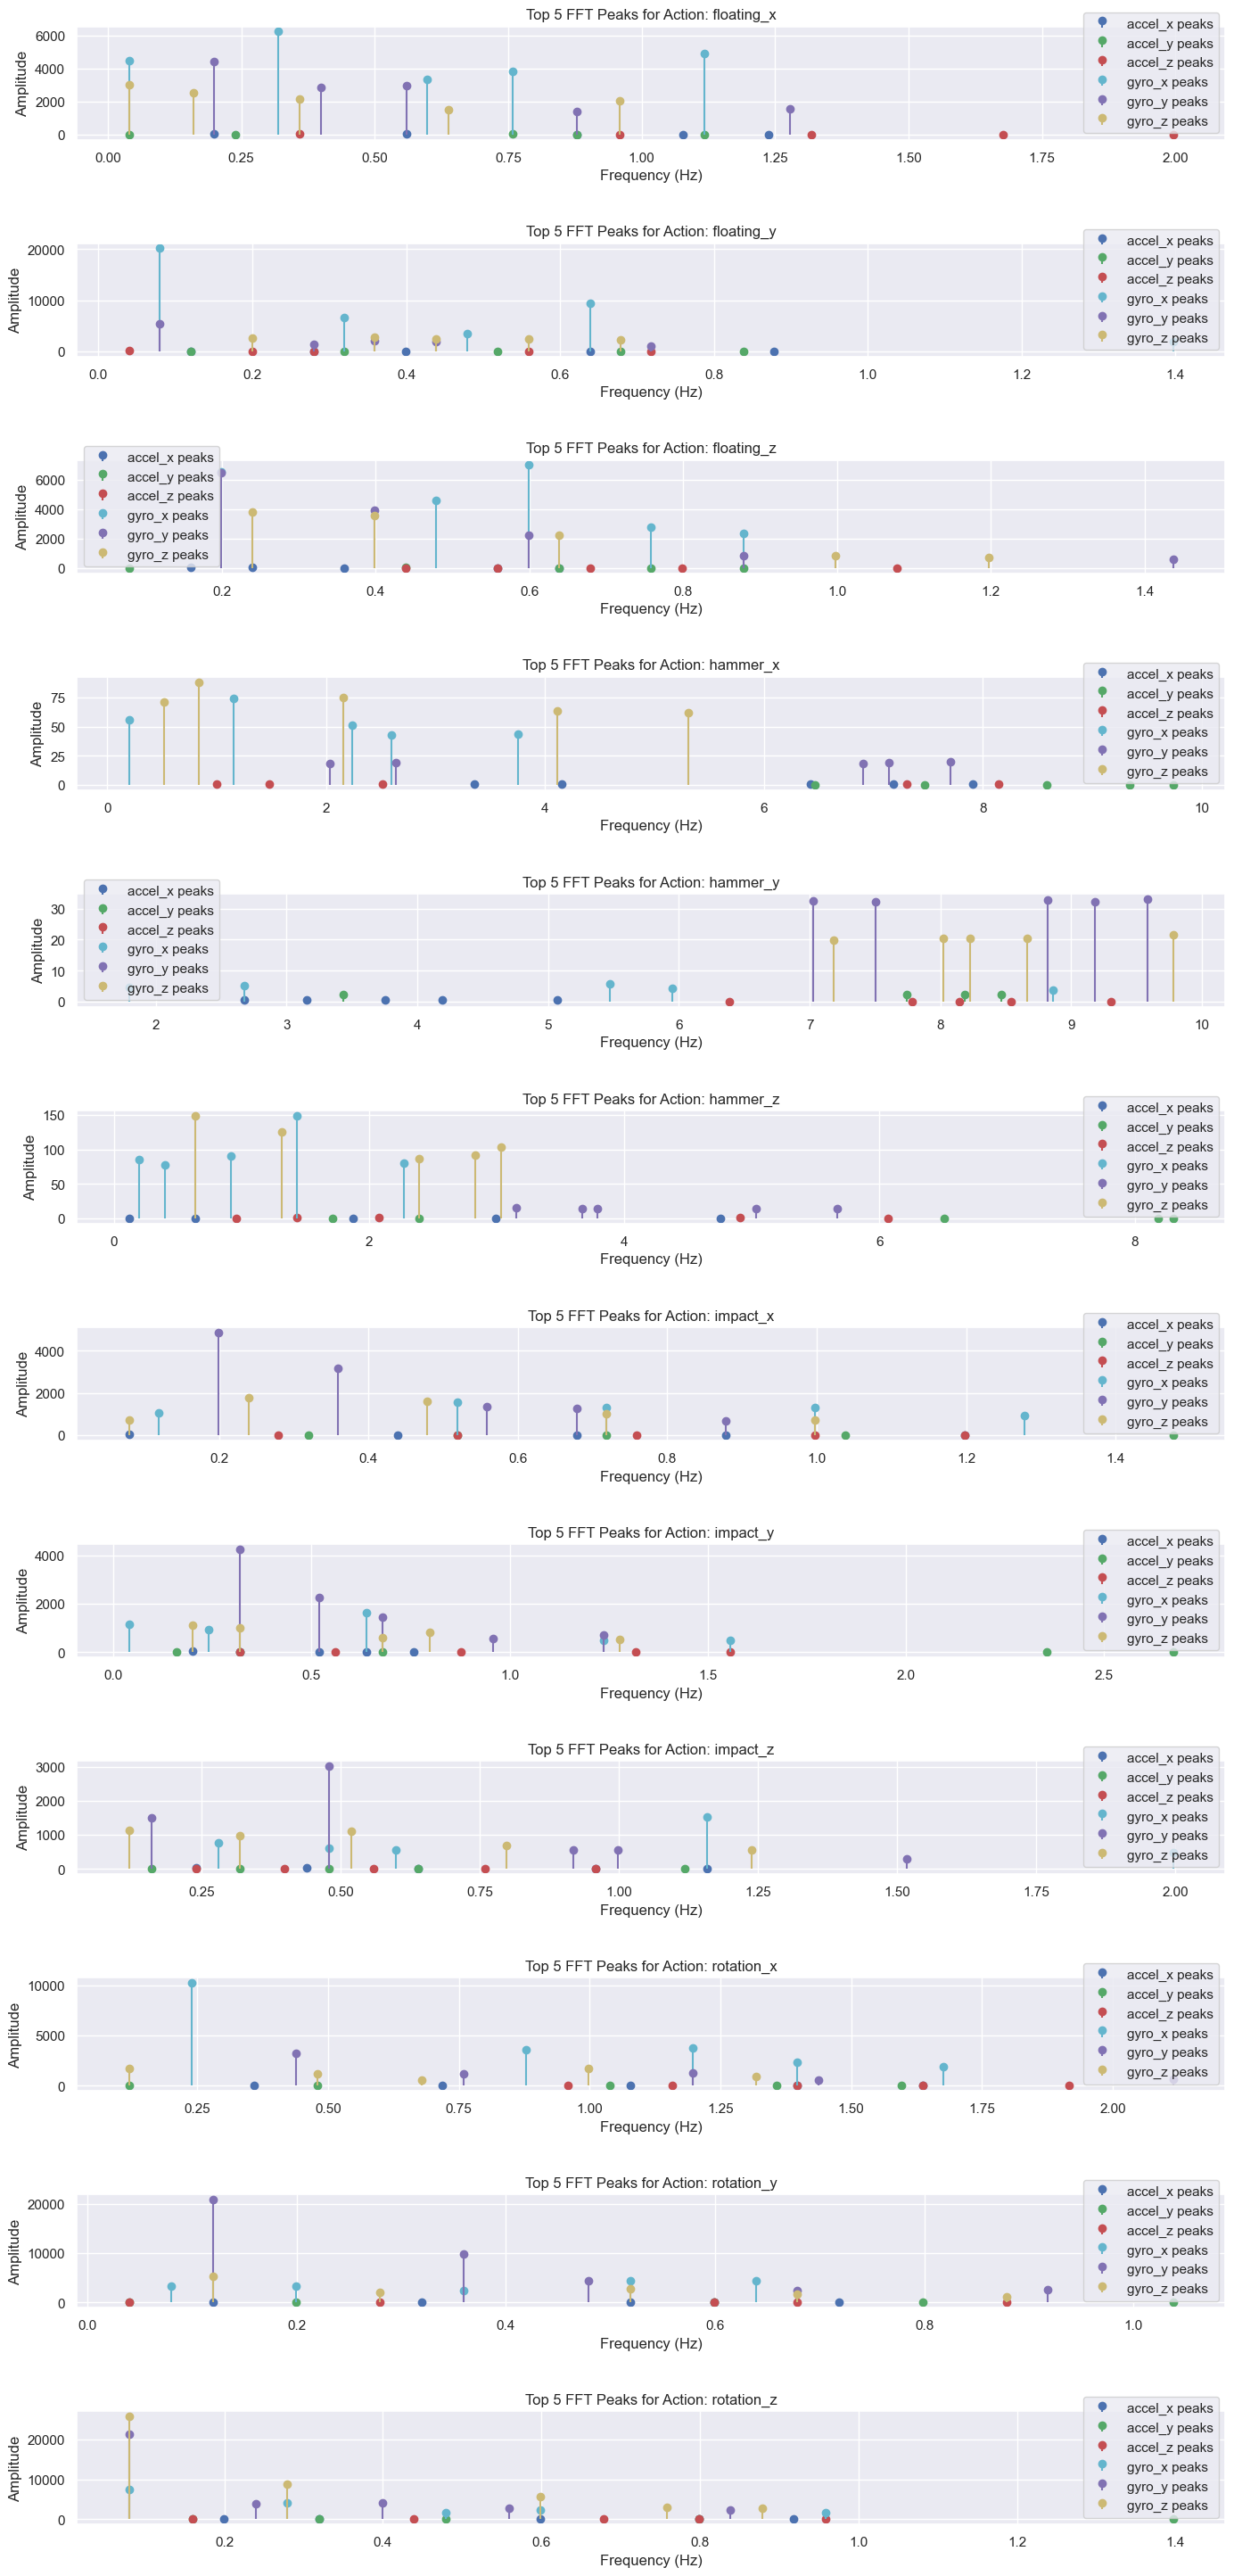

In [29]:
# Group the data by action
grouped_data = data.groupby('action')

# Find the longest sequence length in the dataset for padding
max_length = grouped_data.size().max()

# Set the sampling time
sampling_time = 0.05  # in seconds

# Define sensor components to analyze
components = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Plot the top FFT peaks for each action
plot_top_fft_peaks(grouped_data, components, max_length, sampling_time)


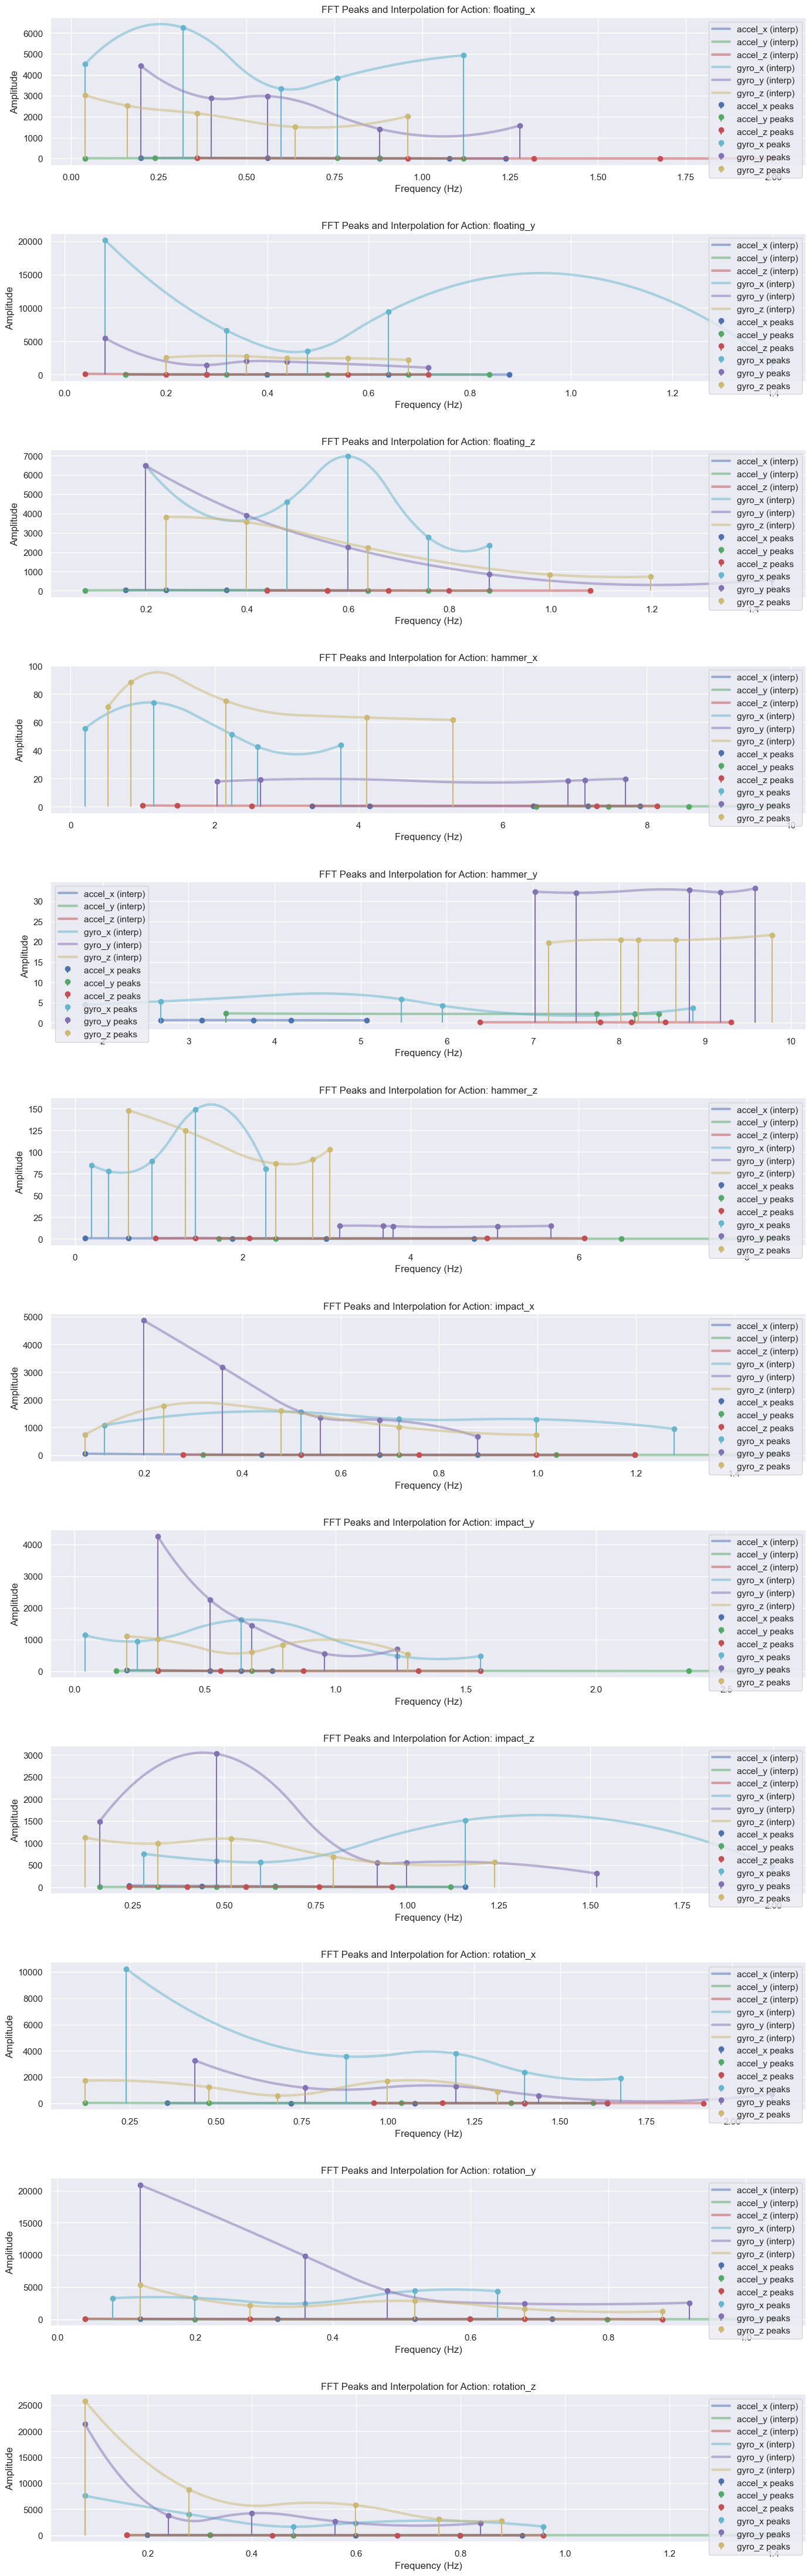

In [30]:
# plot_interpolated_fft(grouped_data, components, max_length, sampling_time)
plot_fft_peaks_with_interpolation(grouped_data, components, max_length, sampling_time)

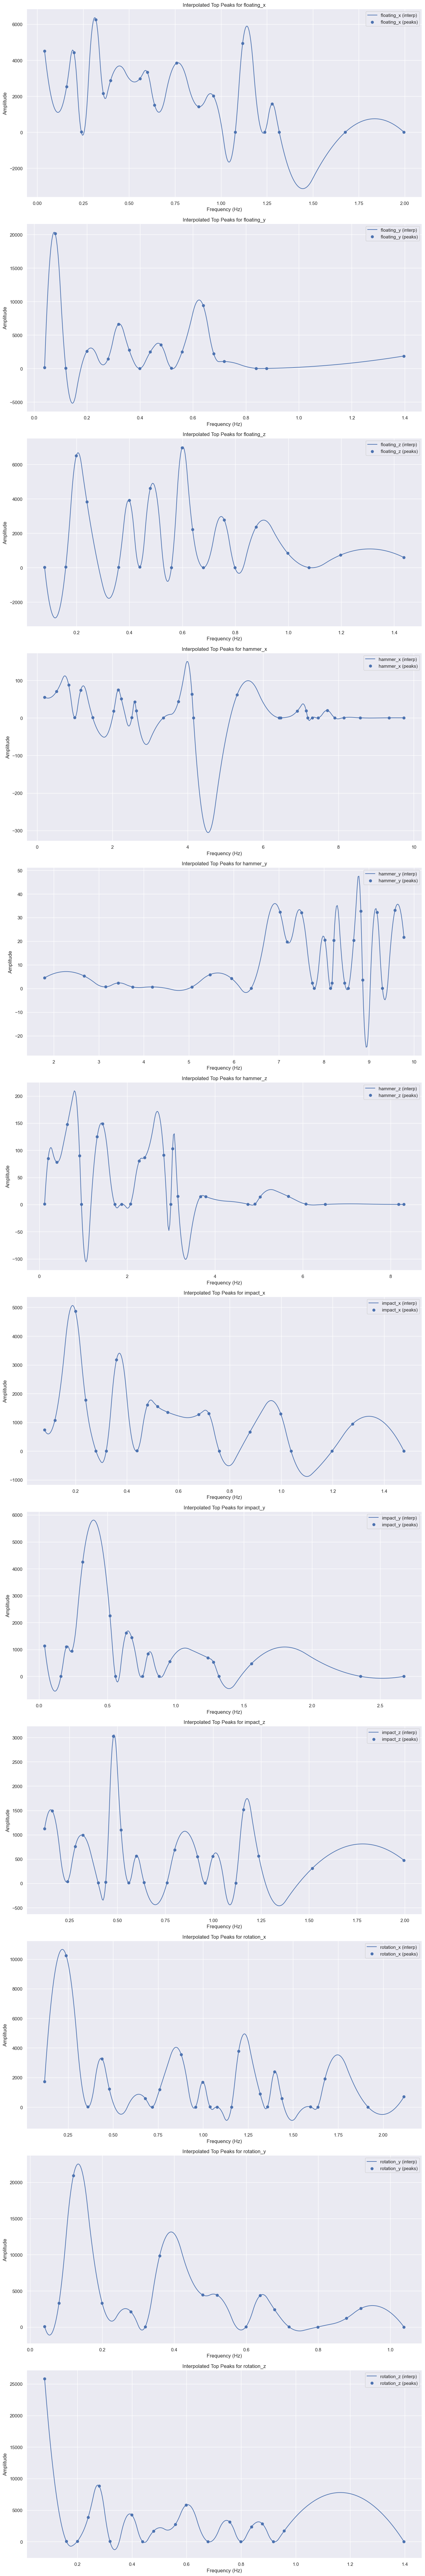

In [31]:
# plot_single_interpolated_function(grouped_data, components, max_length, sampling_time)
f_interp, top_freqs, top_amplitudes = plot_interpolated_top_peaks(grouped_data, components, max_length, sampling_time)

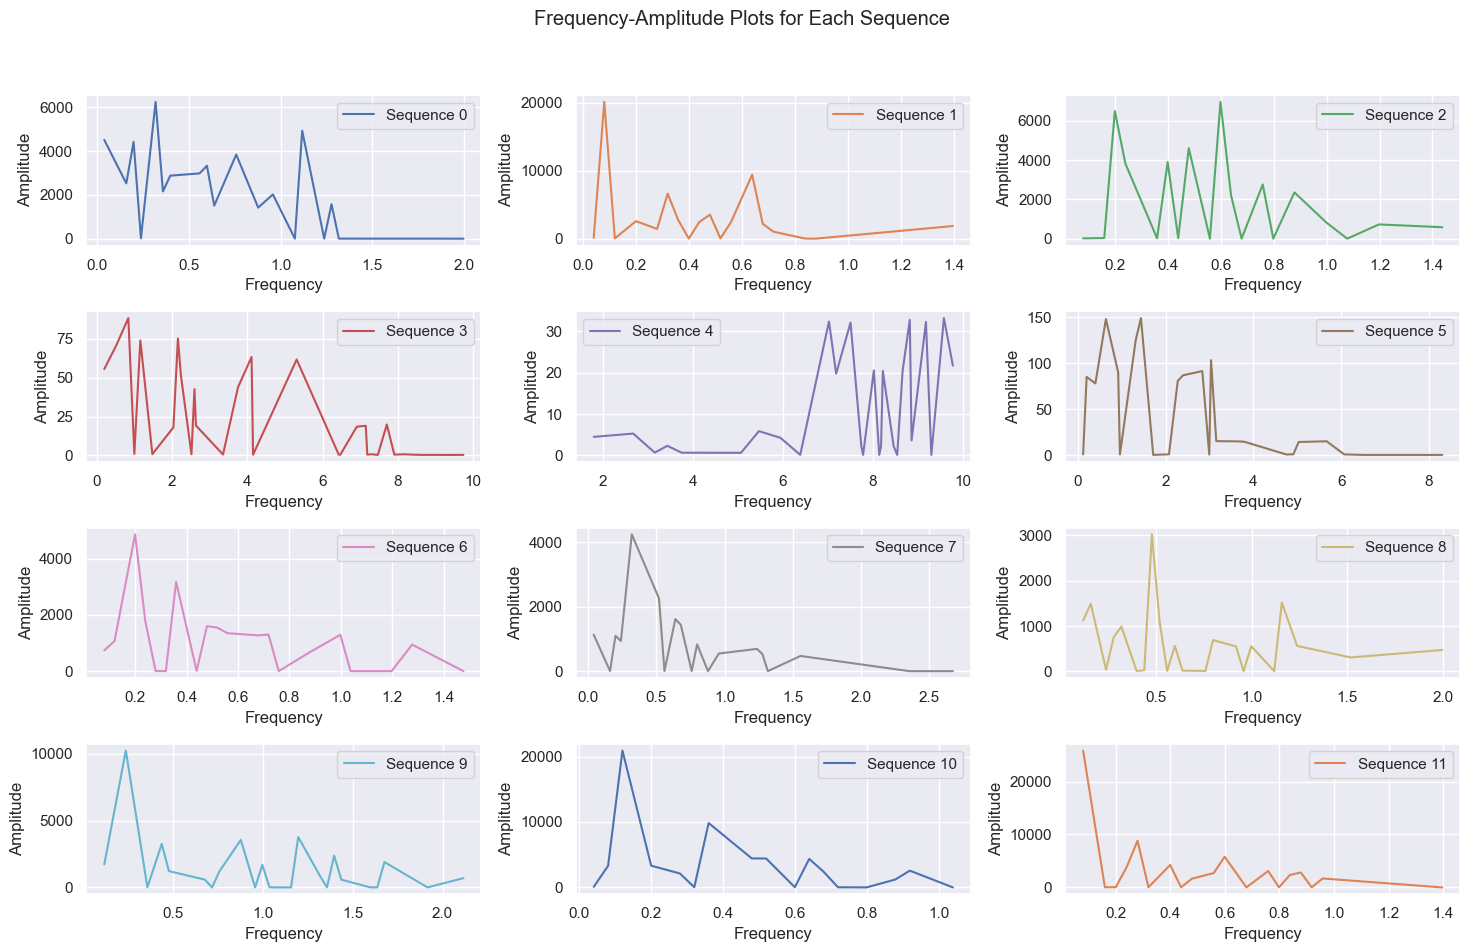

In [75]:
# Ensure that the lengths of top_freqs and top_amplitudes are the same
assert len(top_freqs) == len(top_amplitudes), "The lists top_freqs and top_amplitudes must have the same length."

# Create a 4x3 subplot layout
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
axs = axs.flatten() # Flatten the array of axes for easy indexing

# Iterate over the sequences and plot them in separate subplots
for i in range(len(top_freqs)):
    axs[i].plot(top_freqs[i], top_amplitudes[i], label=f'Sequence {i}', color = 'C'+str(i))
    axs[i].set_xlabel('Frequency')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()

# Adding a super title for the entire figure
plt.suptitle('Frequency-Amplitude Plots for Each Sequence')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

In [76]:
# Create an empty matrix for distances
similarity_matrix = np.zeros((len(top_freqs), len(top_freqs)))

# Calculate DTW distance for each pair of frequency sequences
for i in range(len(top_freqs)):
    for j in range(len(top_freqs)):
        if i != j:  # Avoid computing distance between the same sequences
            distance = dtw.distance(top_freqs[i], top_freqs[j])
            similarity_matrix[i][j] = distance

In [78]:
# Combine frequency and amplitude into a list of 2D points for each sequence
combined_sequences = [np.column_stack((freqs, amps)) for freqs, amps in zip(top_freqs, top_amplitudes)]

# Calculate DTW distance matrix for the combined sequences
# Using 'distance_matrix_fast' for multivariate sequences
similarity_matrix = dtw.distance_matrix_fast(combined_sequences, parallel=True)



In [71]:
# # Determine the new common set of frequency points for interpolation
# # You might choose the union of all frequencies, or perhaps a regular spacing that makes sense for your data
# common_freqs = np.linspace(min(map(min, top_freqs)), max(map(max, top_freqs)), num=1000)

# # Perform the interpolation for each sequence
# interpolated_sequences = []
# for freqs, amps in zip(top_freqs, top_amplitudes):
#     # Ensure there are at least three data points for quadratic interpolation
#     if len(freqs) > 2:
#         interp_func = interp1d(freqs, amps, kind='quadratic', bounds_error=False, fill_value='extrapolate')
#         interpolated_amps = interp_func(common_freqs)
#         interpolated_sequences.append(np.column_stack((common_freqs, interpolated_amps)))
#     else:
#         # If a sequence has less than 3 points, you can't use quadratic interpolation
#         # You'll need to decide how to handle this case
#         print(f"Sequence with frequencies {freqs} has less than 3 points and cannot be interpolated quadratically.")

# # Now that you have your interpolated sequences, you can calculate the DTW distance matrix
# similarity_matrix = dtw.distance_matrix_fast(interpolated_sequences, parallel=True)


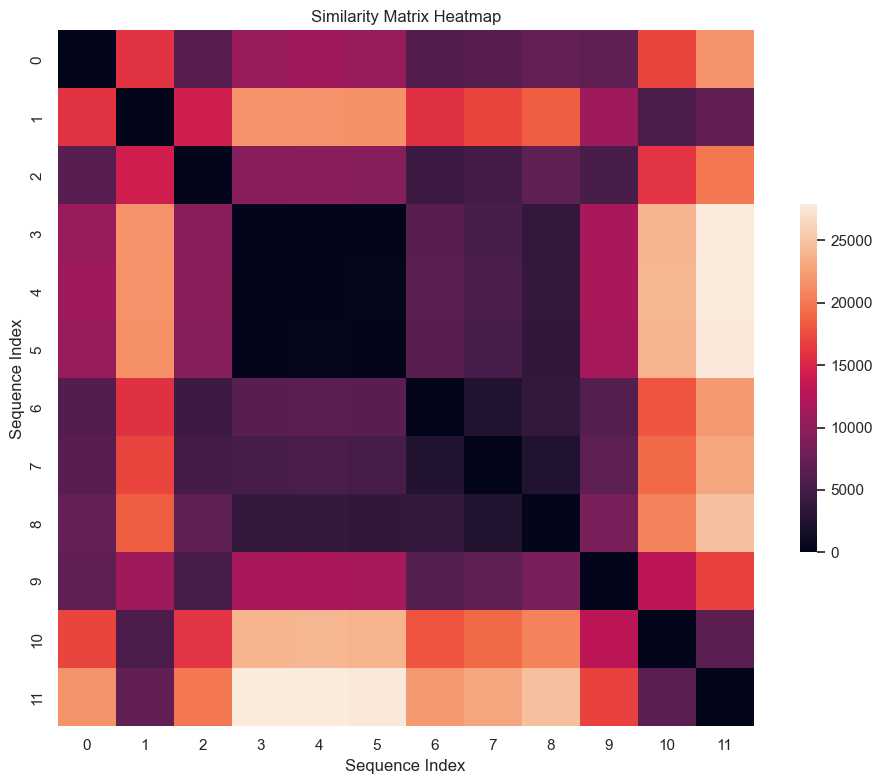

In [79]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(similarity_matrix, square=True, annot=False, fmt='.1e', cbar_kws={"shrink": .5})

plt.title('Similarity Matrix Heatmap')
plt.xlabel('Sequence Index')
plt.ylabel('Sequence Index')

# Optionally adjust the layout
plt.tight_layout()

# Show the plot
plt.show()